In [1]:
import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]: 
    dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [3]:
# LOAD TRAIN
X_train = pd.read_csv('../input/train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('../input/train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv('../input/test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('../input/test_identity.csv',index_col='TransactionID', dtype=dtypes)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (506691, 213)


In [4]:
# Normalize the D columns
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 

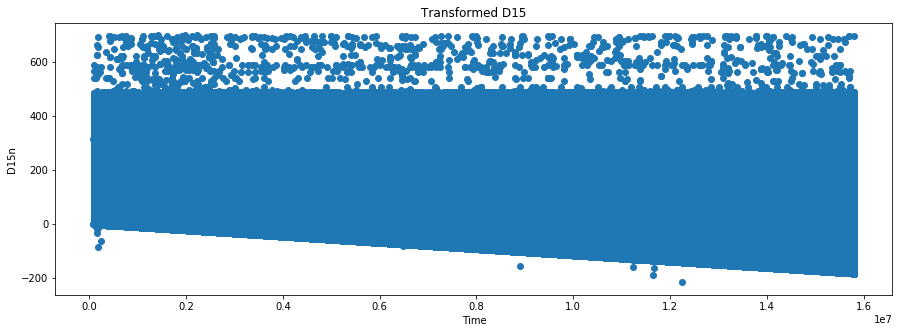

In [5]:
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

## Encoding functions

In [6]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

# Feature Engineering

included features are choosen with validation

In [7]:
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , 

## Feature Selection - Time consistency

The idea is to train a model on each feature and validate with the last month of test data. Remove features whose model have a AUC below 0.5

In [8]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [9]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 215 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

## Tune

In [9]:
X_train.columns

Index(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=213)

In [10]:
X_train_base = X_train[cols]
X_test_base = X_test[cols]

In [11]:
import sys
sys.path.append('/Users/raynoldng/Projects/ieee-fraud-detection')
# sys.path.append('/home/raynoldng/Desktop/ieee-fraud-detection')
from fraud.lightgbm_tuning import tune

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [13]:
bound_lgb = {
    "num_leaves": (70, 900),
    "min_child_weight": (0.001, 0.07),
    "feature_fraction": (0.1, 0.9),
    "bagging_fraction": (0.1, 0.9),
    "max_depth": (-1, 50),
    "learning_rate": (0.05, 0.9),
    "reg_alpha": (0.3, 0.9),
    "reg_lambda": (0.3, 0.9),
    "min_data_in_leaf": (50, 300),
}

target, params = tune(X_train_base, y_train, bound_lgb)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_da... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8339   |  0.3996   |  0.8606   |  0.6722   |  29.53    |  0.01177  |  89.0     |  118.2    |  0.8197   |  0.6607   |
|  2        |  0.843    |  0.6665   |  0.1165   |  0.8744   |  41.45    |  0.01565  |  95.46    |  222.2    |  0.4825   |  0.6149   |
|  3        |  0.8775   |  0.4456   |  0.333    |  0.5701   |  6.114    |  0.02116  |  141.6    |  448.5    |  0.7711   |  0.4198   |
|  4        |  0.934    |  0.5114   |  0.5739   |  0.08948  |  29.98    |  0.01277  |  66.26    |  857.6    |  0.8794   |  0.785    |
|  5        |  0.8778   |  0.3437   |  0.1781   |  0.6316   |  21

In [15]:
params

{'bagging_fraction': 0.89999999999662816,
 'feature_fraction': 0.89174647318118494,
 'learning_rate': 0.050000000000000003,
 'max_depth': 50.0,
 'min_child_weight': 0.069999999984839037,
 'min_data_in_leaf': 159.52482061558243,
 'num_leaves': 899.98019743237455,
 'reg_alpha': 0.3858494493058941,
 'reg_lambda': 0.90000000000000002}

## Helper functions

In [24]:
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

def train_model_with_params(train, test_y, params):
    params['max_depth'] = int(params['max_depth'])
    params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
    params['num_leaves'] = int(params['num_leaves'])
    
    d_train = lgb.Dataset(train, label=test_y)
    model = lgb.train(params, d_train, verbose_eval=False, num_boost_round=1000)
    
    return model

def create_submission(model, X_test, name="submit.csv"):
    predict = model.predict(X_test)
    predict[predict > 1] = 1
    predict[predict < 0] = 0
    sample_submission = pd.read_csv('../input/sample_submission.csv')
    submission = pd.DataFrame({
        'TransactionID': sample_submission['TransactionID'],
        'isFraud': predict
    })
    submission.to_csv(name, index=False)


def feature_important(model, X , num = 50):
    feature_import = pd.DataFrame(sorted(zip(model.feature_importance(), X.columns)), columns = ['values', 'columns'])
    plt.figure(figsize = (12,15))
    sns.barplot(x = 'values', y = 'columns', data = feature_import.sort_values(by = 'values', ascending = False)[:num])
    plt.show()

In [19]:
base_model = train_model_with_params(X_train_base, y_train, params)

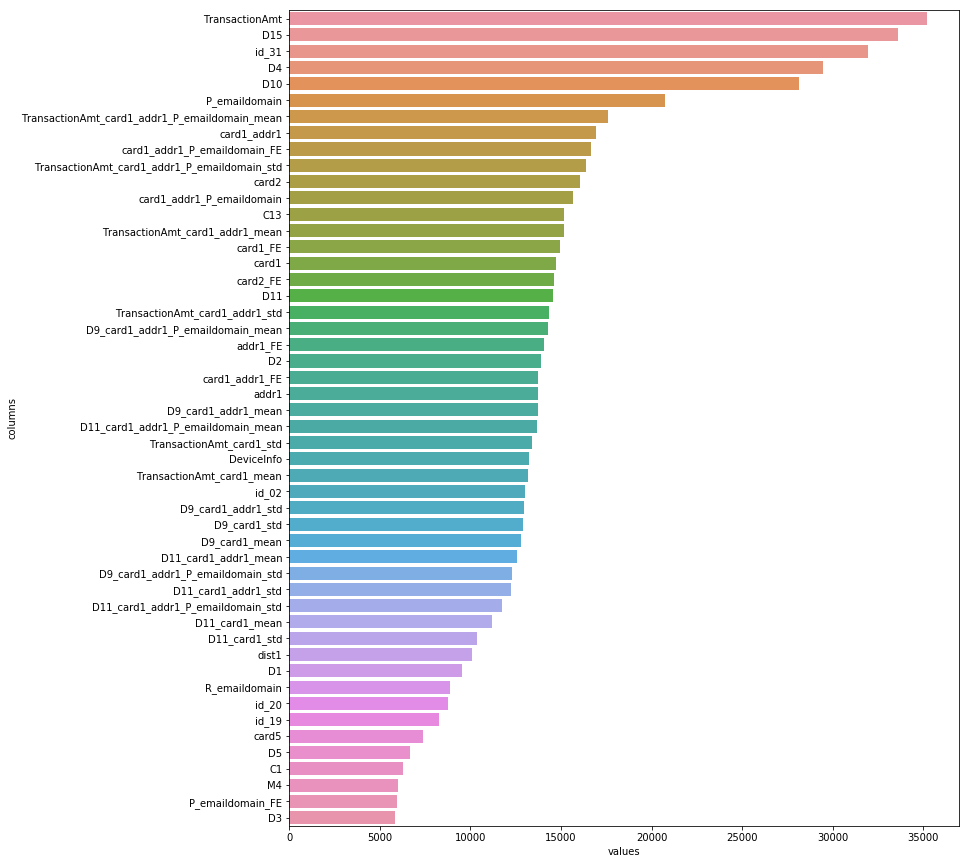

In [20]:
feature_important(base_model, X_train_base)

In [26]:
create_submission(base_model, X_test_base, name="base_submit.csv")

## More Feature Engineering

In [12]:
def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]

    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    dataframe['had_id'] = 1
    gc.collect()
    
    return dataframe

from fraud.feature_engineering import map_emails

In [13]:
ids_for_id_split = ['id_30', 'id_33', 'id_34', 'id_23']
cols2 = cols + ids_for_id_split

X_train_2, X_test_2 = X_train[cols2], X_test[cols2]
X_train_2 = id_split(X_train_2)
X_test_2 = id_split(X_test_2)

X_train_2 = map_emails(X_train_2)
X_test_2 = map_emails(X_test_2)

In [14]:
prob_cols = ['id_34', 'id_23', 'device_name', 'device_version', 'OS_id_30', 'version_id_30', 'browser_id_31', 'version_id_31', 
             'screen_width', 'screen_height', 'P_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_bin', 'R_emaildomain_suffix']
for col in prob_cols:
    X_train_2[col] = X_train_2[col].astype('category')
    X_test_2[col] = X_test_2[col].astype('category')

In [15]:
X_train_2[prob_cols].head()

,id_34,id_23,device_name,device_version,OS_id_30,version_id_30,browser_id_31,version_id_31,screen_width,screen_height,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix
TransactionID,,,,,,,,,,,,,,
2987000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,google,com,NaN,NaN
2987002.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,microsoft,com,NaN,NaN
2987003.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yahoo,com,NaN,NaN
2987004.0,2,NaN,Samsung,NRD90M,Android,7.0,samsung,browser,2220,1080,google,com,NaN,NaN


In [65]:
bound_lgb = {
    "num_leaves": (70, 1200), # increased
    "min_child_weight": (0.001, 0.07),
    "feature_fraction": (0.1, 0.9),
    "bagging_fraction": (0.1, 0.9),
    "max_depth": (-1, 60), # increased
    "learning_rate": (0.025, 0.9), # decreased
    "reg_alpha": (0.3, 0.9),
    "reg_lambda": (0.3, 0.9),
    "min_data_in_leaf": (50, 300),
}

target, params = tune(X_train_2, y_train, bound_lgb)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_da... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8354   |  0.3996   |  0.8606   |  0.6655   |  35.52    |  0.01177  |  89.0     |  135.6    |  0.8197   |  0.6607   |
|  2        |  0.8292   |  0.6665   |  0.1165   |  0.8737   |  49.78    |  0.01565  |  95.46    |  277.2    |  0.4825   |  0.6149   |
|  3        |  0.88     |  0.4456   |  0.333    |  0.5604   |  7.509    |  0.02116  |  141.6    |  585.4    |  0.7711   |  0.4198   |
|  4        |  0.9342   |  0.5114   |  0.5739   |  0.06564  |  36.06    |  0.01277  |  66.26    |  1.142e+0 |  0.8794   |  0.785    |
|  5        |  0.8323   |  0.3437   |  0.1781   |  0.6237   |  25

In [66]:
params

{'bagging_fraction': 0.51138755073088926,
 'feature_fraction': 0.57393165508963395,
 'learning_rate': 0.065644111129998017,
 'max_depth': 36.060235965987744,
 'min_child_weight': 0.012766164534423117,
 'min_data_in_leaf': 66.262898246319878,
 'num_leaves': 1142.2406570962667,
 'reg_alpha': 0.87937921984473566,
 'reg_lambda': 0.78503840886987675}

In [67]:
model2 = train_model_with_params(X_train_2, y_train, params)

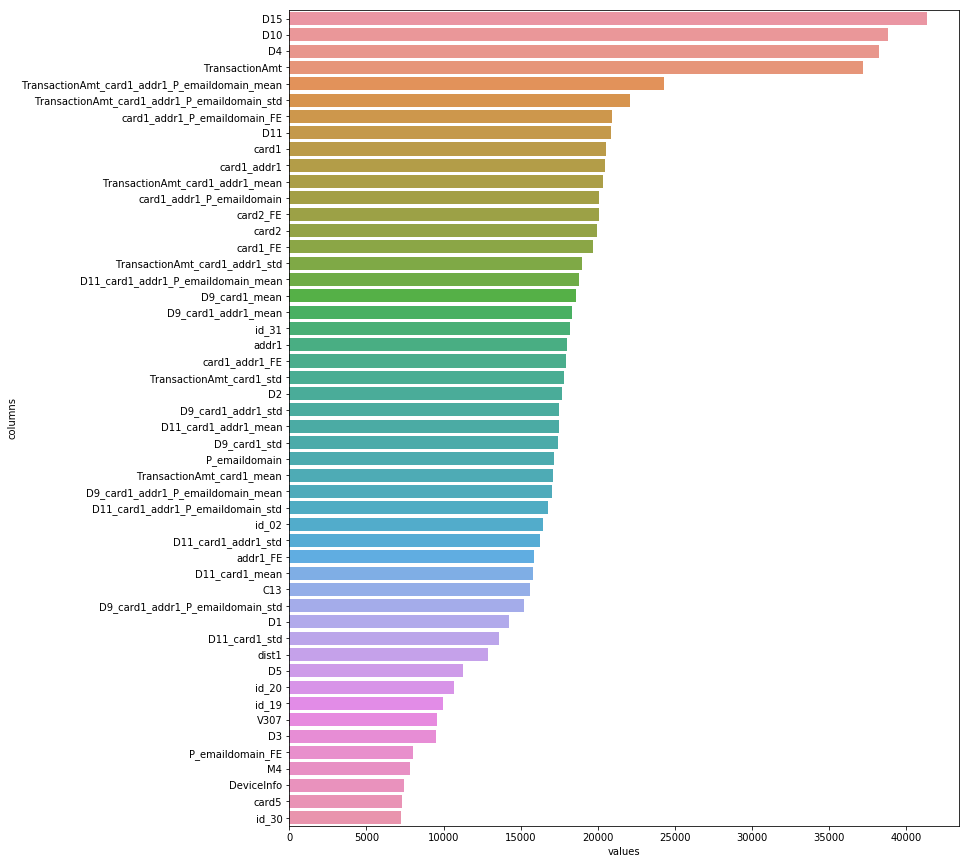

In [68]:
feature_important(model2, X_train_2)

In [70]:
create_submission(model2, X_test_2, name="device_email_submit.csv")

In [72]:
# save models
base_model.save_model('../models/encoding_base.txt')
model2.save_model('../models/encoding_email_device_info.txt')

In [20]:
X_test_2.to_pickle('../processed_input/X_test_encoding_deviceinfo_email.pkl')
X_train_2.to_pickle('../processed_input/X_train_encoding_deviceinfo_email.pkl')

In [ ]:
prob_cols = ['id_34', 'id_23', 'device_name', 'device_version', 'OS_id_30', 'version_id_30', 'browser_id_31', 'version_id_31', 
             'screen_width', 'screen_height', 'P_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_bin', 'R_emaildomain_suffix']
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
encode_FE(X_train_2, X_test_2, )
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

In [74]:
y_train

TransactionID
2987000.0    0
2987001.0    0
2987002.0    0
2987003.0    0
2987004.0    0
            ..
3577535.0    0
3577536.0    0
3577537.0    0
3577538.0    0
3577539.0    0
Name: isFraud, Length: 590540, dtype: int64

In [75]:
y_train

TransactionID
2987000.0    0
2987001.0    0
2987002.0    0
2987003.0    0
2987004.0    0
            ..
3577535.0    0
3577536.0    0
3577537.0    0
3577538.0    0
3577539.0    0
Name: isFraud, Length: 590540, dtype: int64